In [1]:
import torch
import torch.nn as nn

import numpy as np 
import matplotlib.pyplot as plt

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import SingleLetterAlphabet

from transformers import AutoTokenizer, AutoModel, EsmForProteinFolding

import os
import copy
from tqdm import tqdm

from linear_quant import *
import seaborn as sns
# sns.set(color_codes=True)

2023-03-13 10:44:04.415722: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 10:44:04.546830: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-13 10:44:05.085166: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-13 10:44:05.085276: W tensorflow/

In [2]:
# act_stats_save_path = 'stats/act_stats_50_layernorm.pth'
# acts_dict = torch.load(act_stats_save_path)

# stats = acts_dict["esm.encoder.layer.35.LayerNorm.0.maxv"]
# stats = stats[:, -50:]
# values, indices = torch.median(stats, 1)
# print(torch.mean(values).item())

# stats = acts_dict["esm.encoder.layer.35.LayerNorm.0.minv"]
# stats = stats[:, :50]
# values, indices = torch.median(stats, 1)
# print(torch.mean(values).item())

# print("==================================================")

# act_stats_save_path = 'stats/act_stats_50_layernorm_v2.pth'
# acts_dict = torch.load(act_stats_save_path)

# stats = acts_dict["esm.encoder.layer.35.LayerNorm.0.maxv"]
# stats = stats[:, -50:]
# values, indices = torch.median(stats, 1)
# print(torch.mean(values).item())

# stats = acts_dict["esm.encoder.layer.35.LayerNorm.0.minv"]
# stats = stats[:, :50]
# values, indices = torch.median(stats, 1)
# print(torch.mean(values).item())

In [2]:
origin_model = EsmForProteinFolding.from_pretrained("facebook/esmfold_v1", low_cpu_mem_usage=False)
quant_model = torch.load("/HOME/quant_model_8b_full_origin.pt")
origin_model = origin_model.cuda("cuda:0")
quant_model = quant_model.cuda("cuda:0")

Downloading:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.44G [00:00<?, ?B/s]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_6821/1149049594.py:1 in <module>                                                  │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_6821/1149049594.py'                         │
│                                                                                                  │
│ /usr/local/lib/python3.8/dist-packages/transformers/modeling_utils.py:2091 in from_pretrained    │
│                                                                                                  │
│   2088 │   │   │   │   │   │   _raise_exceptions_for_missing_entries=False,                      │
│   2089 │   │   │   │   │   │   _commit_hash=commit_hash,                                         │
│   2090 │   │   │   │   │   )                                                                     │
│ ❱ 2091 │   │   │   │   │   resolved_archive_file = cached_file(pretrained_model_name_or_path, f  │
│   2092 │   │   │   │   │                                                                         │
│   2093 │   │   │   │   │   # Since we set _raise_exceptions_for_missing_entries=False, we don't  │
│   2094 │   │   │   │   │   # result when internet is up, the repo and revision exist, but the f  │
│                                                                                                  │
│ /usr/local/lib/python3.8/dist-packages/transformers/utils/hub.py:409 in cached_file              │
│                                                                                                  │
│    406 │   user_agent = http_user_agent(user_agent)                                              │
│    407 │   try:                                                                                  │
│    408 │   │   # Load from URL or cache if already cached                                        │
│ ❱  409 │   │   resolved_file = hf_hub_download(                                                  │
│    410 │   │   │   path_or_repo_id,                                                              │
│    411 │   │   │   filename,                                                                     │
│    412 │   │   │   subfolder=None if len(subfolder) == 0 else subfolder,                         │
│                                                                                                  │
│ /usr/local/lib/python3.8/dist-packages/huggingface_hub/utils/_validators.py:124 in _inner_fn     │
│                                                                                                  │
│   121 │   │   │   │   fn_name=fn.__name__, has_token=has_token, kwargs=kwargs                    │
│   122 │   │   │   )                                                                              │
│   123 │   │                                                                                      │
│ ❱ 124 │   │   return fn(*args, **kwargs)                                                         │
│   125 │                                                                                          │
│   126 │   return _inner_fn  # type: ignore                                                       │
│   127                                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.8/dist-packages/huggingface_hub/file_download.py:1240 in hf_hub_download  │
│                                                                                                  │
│   1237 │   │   with temp_file_manager() as temp_file:                                            │
│   1238 │   │   │   logger.info("downloading %s to %s", url, temp_file.name)                      │
│   1239 │   │   │                                           

In [9]:
quant_model.state_dict()

OrderedDict([('esm_s_combine',
              tensor([-1.2234,  3.5496,  0.4244, -1.4940, -2.2194, -3.1289, -3.5511, -3.5746,
                      -3.7223, -3.1634, -2.9362, -2.6054, -2.1952, -1.7772, -0.9906, -0.8907,
                      -1.0638, -0.6449, -0.9879, -1.1915, -1.5288, -1.7939, -1.5323, -1.4875,
                      -1.4648, -1.6018, -1.7573, -1.4258, -1.2659, -0.7845, -0.4117, -0.2084,
                       0.1421,  0.1183, -0.1169,  0.4990,  6.1261], device='cuda:0')),
             ('af2_to_esm',
              tensor([ 1,  5, 10, 17, 13, 23, 16,  9,  6, 21, 12,  4, 15, 20, 18, 14,  8, 11,
                      22, 19,  7, 24], device='cuda:0')),
             ('esm.embeddings.position_ids',
              tensor([[   0,    1,    2,  ..., 1023, 1024, 1025]], device='cuda:0')),
             ('esm.embeddings.word_embeddings.weight',
              tensor([[-0.0545,  0.0216,  0.0240,  ..., -0.2219,  0.0329,  0.0653],
                      [ 0.0245,  0.0174,  0.0066,  ..., 

In [4]:
# seq_fasta = list(SeqIO.parse("casp14.fasta", "fasta"))
seq_fasta = list(SeqIO.parse("sequences_cameo.fasta", "fasta"))

test_protein = seq_fasta[0].seq.__str__()

tokenizer = AutoTokenizer.from_pretrained("facebook/esmfold_v1")
tokenized_input = tokenizer([test_protein], return_tensors="pt", add_special_tokens=False)['input_ids']
tokenized_input = tokenized_input.cuda("cuda:0")

In [5]:
layerNorm_0_input = []
layerNorm_1_input = []
layerNorm_2_input = []
layerNorm_3_input = []
layerNorm_4_input = []
layerNorm_5_input = []

quant_layerNorm_0_input = []
quant_layerNorm_1_input = []
quant_layerNorm_2_input = []
quant_layerNorm_3_input = []
quant_layerNorm_4_input = []
quant_layerNorm_5_input = []

layerNorm_0_output = []
layerNorm_1_output = []
layerNorm_2_output = []
layerNorm_3_output = []
layerNorm_4_output = []
layerNorm_5_output = []

quant_layerNorm_0_output = []
quant_layerNorm_1_output = []
quant_layerNorm_2_output = []
quant_layerNorm_3_output = []
quant_layerNorm_4_output = []
quant_layerNorm_5_output = []
  
def hook1(module, input, output): 
    layerNorm_0_output.append(output)
    
def hook2(module, input, output): 
    layerNorm_1_output.append(output)
    
def hook3(module, input, output): 
    layerNorm_2_output.append(output)

def hook4(module, input, output): 
    layerNorm_3_output.append(output)

def hook5(module, input, output): 
    layerNorm_4_output.append(output)
    
def hook6(module, input, output): 
    layerNorm_5_output.append(output)
    
def hook7(module, input, output): 
    quant_layerNorm_0_output.append(output)

def hook8(module, input, output): 
    quant_layerNorm_1_output.append(output)
    
def hook9(module, input, output): 
    quant_layerNorm_2_output.append(output)
    
def hook10(module, input, output): 
    quant_layerNorm_3_output.append(output)
    
def hook11(module, input, output): 
    quant_layerNorm_4_output.append(output)
    
def hook12(module, input, output): 
    quant_layerNorm_5_output.append(output)

def hook13(module, input, output): 
    layerNorm_0_input.append(input)
    
def hook14(module, input, output): 
    layerNorm_1_input.append(input)
    
def hook15(module, input, output): 
    layerNorm_2_input.append(input)

def hook16(module, input, output): 
    layerNorm_3_input.append(input)

def hook17(module, input, output): 
    layerNorm_4_input.append(input)
    
def hook18(module, input, output): 
    layerNorm_5_input.append(input)
    
def hook19(module, input, output): 
    quant_layerNorm_0_input.append(input)

def hook20(module, input, output): 
    quant_layerNorm_1_input.append(input)
    
def hook21(module, input, output): 
    quant_layerNorm_2_input.append(input)
    
def hook22(module, input, output): 
    quant_layerNorm_3_input.append(input)
    
def hook23(module, input, output): 
    quant_layerNorm_4_input.append(input)
    
def hook24(module, input, output): 
    quant_layerNorm_5_input.append(input)


handle1 = list(origin_model.esm.encoder.layer.children())[0].LayerNorm.register_forward_hook(hook1)
handle2 = list(origin_model.esm.encoder.layer.children())[1].LayerNorm.register_forward_hook(hook2)
handle3 = list(origin_model.esm.encoder.layer.children())[2].LayerNorm.register_forward_hook(hook3)
handle4 = list(origin_model.esm.encoder.layer.children())[33].LayerNorm.register_forward_hook(hook4)
handle5 = list(origin_model.esm.encoder.layer.children())[34].LayerNorm.register_forward_hook(hook5)
handle6 = list(origin_model.esm.encoder.layer.children())[35].LayerNorm.register_forward_hook(hook6)

handle7 = list(quant_model.esm.encoder.layer.children())[0].LayerNorm.register_forward_hook(hook7)
handle8 = list(quant_model.esm.encoder.layer.children())[1].LayerNorm.register_forward_hook(hook8)
handle9 = list(quant_model.esm.encoder.layer.children())[2].LayerNorm.register_forward_hook(hook9)
handle10 = list(quant_model.esm.encoder.layer.children())[33].LayerNorm.register_forward_hook(hook10)
handle11 = list(quant_model.esm.encoder.layer.children())[34].LayerNorm.register_forward_hook(hook11)
handle12 = list(origin_model.esm.encoder.layer.children())[35].LayerNorm.register_forward_hook(hook12)

handle13 = list(origin_model.esm.encoder.layer.children())[0].LayerNorm.register_forward_hook(hook13)
handle14 = list(origin_model.esm.encoder.layer.children())[1].LayerNorm.register_forward_hook(hook14)
handle15 = list(origin_model.esm.encoder.layer.children())[2].LayerNorm.register_forward_hook(hook15)
handle16 = list(origin_model.esm.encoder.layer.children())[33].LayerNorm.register_forward_hook(hook16)
handle17 = list(quant_model.esm.encoder.layer.children())[34].LayerNorm.register_forward_hook(hook17)
handle18 = list(quant_model.esm.encoder.layer.children())[35].LayerNorm.register_forward_hook(hook18)

handle19 = list(quant_model.esm.encoder.layer.children())[0].LayerNorm.register_forward_hook(hook19)
handle20 = list(quant_model.esm.encoder.layer.children())[1].LayerNorm.register_forward_hook(hook20)
handle21 = list(quant_model.esm.encoder.layer.children())[2].LayerNorm.register_forward_hook(hook21)
handle22 = list(quant_model.esm.encoder.layer.children())[33].LayerNorm.register_forward_hook(hook22)
handle23 = list(quant_model.esm.encoder.layer.children())[34].LayerNorm.register_forward_hook(hook23)
handle24 = list(quant_model.esm.encoder.layer.children())[35].LayerNorm.register_forward_hook(hook24)

In [6]:
with torch.no_grad():
    output1 = origin_model(tokenized_input)
    output2 = quant_model(tokenized_input)

handle1.remove()
handle2.remove()
handle3.remove()
handle4.remove()
handle5.remove()
handle6.remove()
handle7.remove()
handle8.remove()
handle9.remove()
handle10.remove()
handle11.remove()
handle12.remove()
handle13.remove()
handle14.remove()
handle15.remove()
handle16.remove()
handle17.remove()
handle18.remove()
handle19.remove()
handle20.remove()
handle21.remove()
handle22.remove()
handle23.remove()
handle24.remove()

In [7]:
layerNorm_0_input = layerNorm_0_input[0][0].flatten().tolist()
layerNorm_1_input = layerNorm_1_input[0][0].flatten().tolist()
layerNorm_2_input = layerNorm_2_input[0][0].flatten().tolist()
layerNorm_3_input = layerNorm_3_input[0][0].flatten().tolist()
layerNorm_4_input = layerNorm_4_input[0][0].flatten().tolist()
layerNorm_5_input = layerNorm_5_input[0][0].flatten().tolist()

quant_layerNorm_0_input = quant_layerNorm_0_input[0][0].flatten().tolist()
quant_layerNorm_1_input = quant_layerNorm_1_input[0][0].flatten().tolist()
quant_layerNorm_2_input = quant_layerNorm_2_input[0][0].flatten().tolist()
quant_layerNorm_3_input = quant_layerNorm_3_input[0][0].flatten().tolist()
quant_layerNorm_4_input = quant_layerNorm_4_input[0][0].flatten().tolist()
quant_layerNorm_5_input = quant_layerNorm_5_input[0][0].flatten().tolist()

layerNorm_0_output = layerNorm_0_output[0][0].flatten().tolist()
layerNorm_1_output = layerNorm_1_output[0][0].flatten().tolist()
layerNorm_2_output = layerNorm_2_output[0][0].flatten().tolist()
layerNorm_3_output = layerNorm_3_output[0][0].flatten().tolist()
layerNorm_4_output = layerNorm_4_output[0][0].flatten().tolist()
layerNorm_5_output = layerNorm_5_output[0][0].flatten().tolist()

quant_layerNorm_0_output = quant_layerNorm_0_output[0][0].flatten().tolist()
quant_layerNorm_1_output = quant_layerNorm_1_output[0][0].flatten().tolist()
quant_layerNorm_2_output = quant_layerNorm_2_output[0][0].flatten().tolist()
quant_layerNorm_3_output = quant_layerNorm_3_output[0][0].flatten().tolist()
quant_layerNorm_4_output = quant_layerNorm_4_output[0][0].flatten().tolist()
quant_layerNorm_5_output = quant_layerNorm_5_output[0][0].flatten().tolist()

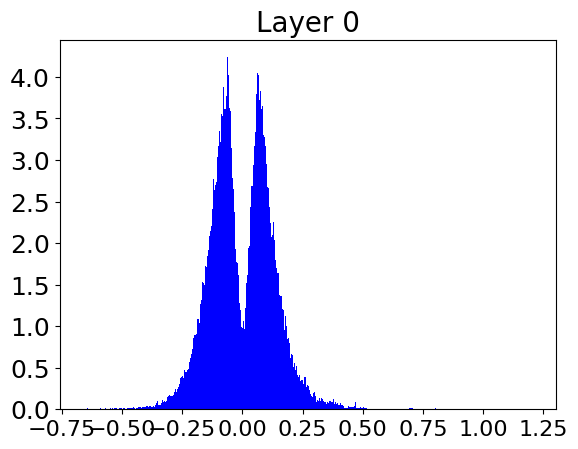

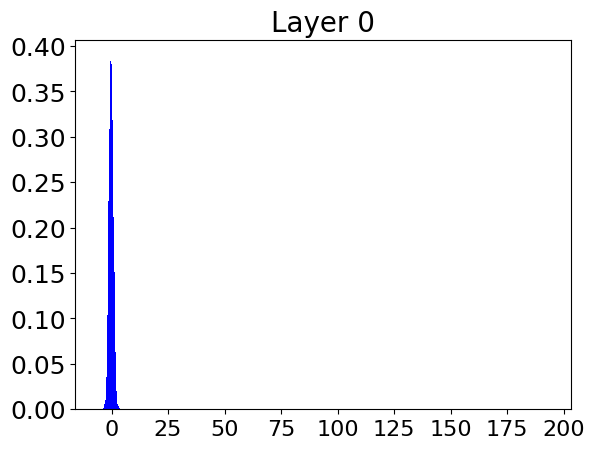

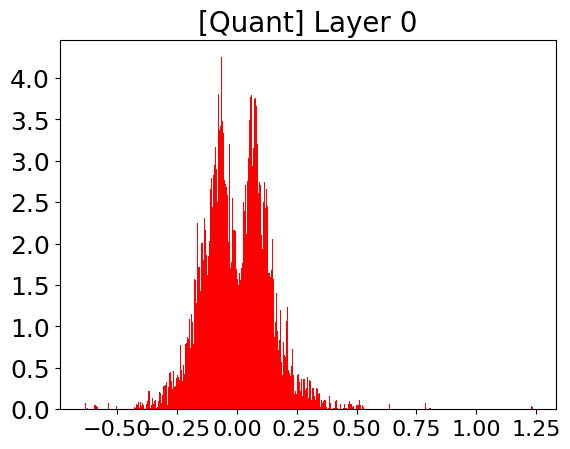

In [8]:
plt.hist(layerNorm_0_output, bins="auto", density=True, facecolor='b')
plt.title("Layer 0", fontdict={"size": 20})
plt.yticks(size = 18)
plt.xticks(size = 16)
plt.savefig("figs/layerNorm_0_output.pdf")
plt.show()

plt.hist(layerNorm_0_input, bins="scott", density=True, facecolor='b')
plt.title("Layer 0", fontdict={"size": 20})
plt.yticks(size = 18)
plt.xticks(size = 16)
plt.savefig("figs/layerNorm_0_input.pdf")
plt.show()

plt.hist(quant_layerNorm_0_output, bins="auto", density=True, facecolor='r')
plt.title("[Quant] Layer 0", fontdict={"size": 20})
plt.yticks(size = 18)
plt.xticks(size = 16)
plt.savefig("figs/quant_layerNorm_0_output.pdf")
plt.show()

In [9]:
# sns.displot(layerNorm_0)
# sns.displot(quant_layerNorm_0)

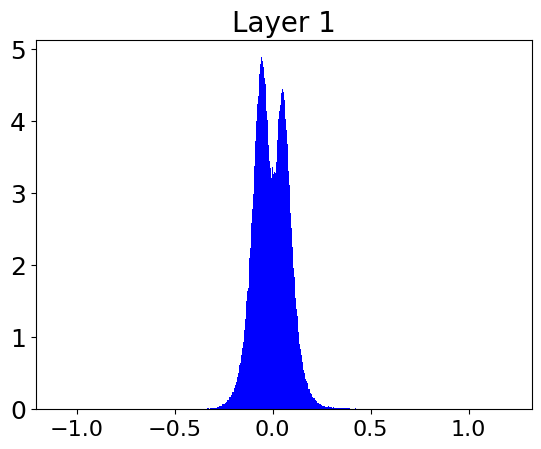

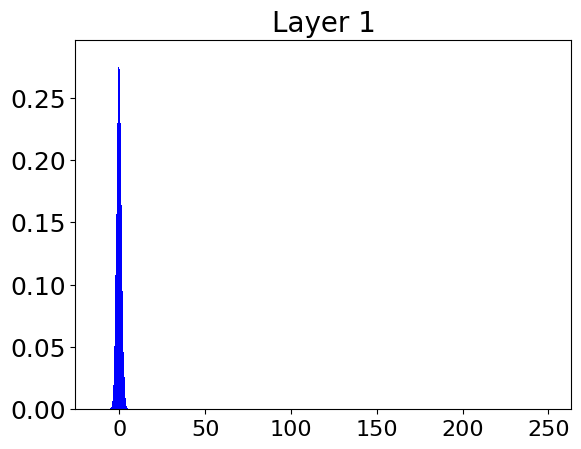

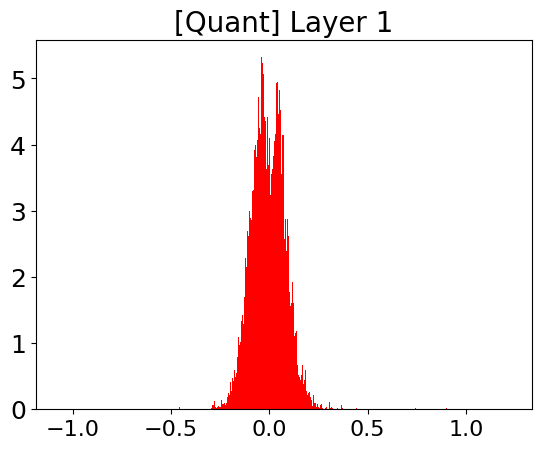

In [10]:
plt.hist(layerNorm_1_output, bins="scott", density=True, facecolor='b')
plt.title("Layer 1", fontdict={"size": 20})
plt.yticks(size = 18)
plt.xticks(size = 16)
plt.savefig("figs/layerNorm_1_output.pdf")
plt.show()

plt.hist(layerNorm_1_input, bins="scott", density=True, facecolor='b')
plt.title("Layer 1", fontdict={"size": 20})
plt.yticks(size = 18)
plt.xticks(size = 16)
plt.savefig("figs/layerNorm_1_input.pdf")
plt.show()

plt.hist(quant_layerNorm_1_output, bins="scott", density=True, facecolor='r')
plt.title("[Quant] Layer 1", fontdict={"size": 20})
plt.yticks(size = 18)
plt.xticks(size = 16)
plt.savefig("figs/quant_layerNorm_1_output.pdf")
plt.show()

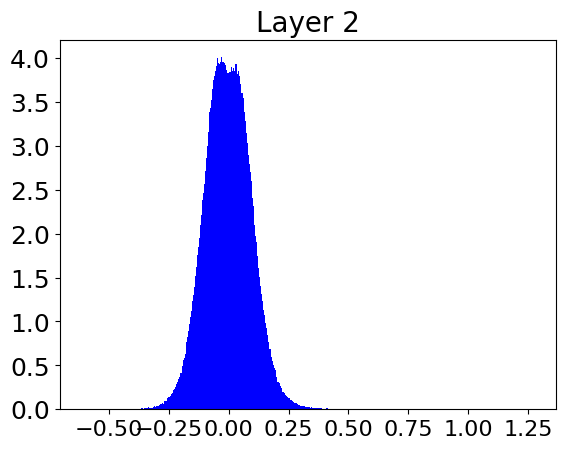

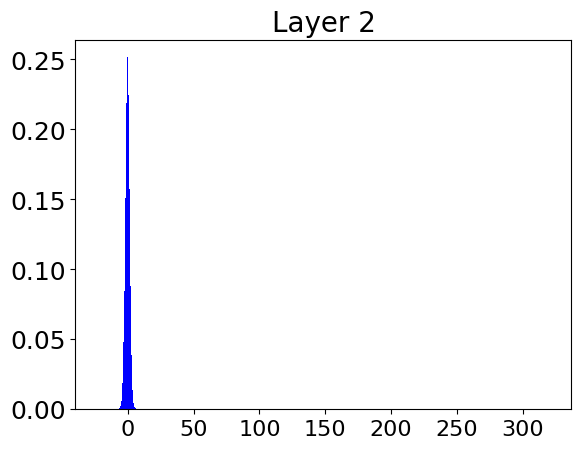

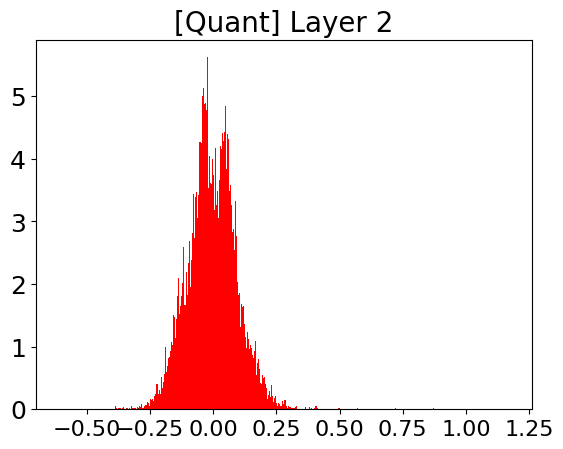

In [11]:
plt.hist(layerNorm_2_output, bins="scott", density=True, facecolor='b')
plt.title("Layer 2", fontdict={"size": 20})
plt.yticks(size = 18)
plt.xticks(size = 16)
plt.savefig("figs/layerNorm_2_output.pdf")
plt.show()

plt.hist(layerNorm_2_input, bins="scott", density=True, facecolor='b')
plt.title("Layer 2", fontdict={"size": 20})
plt.yticks(size = 18)
plt.xticks(size = 16)
plt.savefig("figs/layerNorm_2_input.pdf")
plt.show()

plt.hist(quant_layerNorm_2_output, bins="scott", density=True, facecolor='r')
plt.title("[Quant] Layer 2", fontdict={"size": 20})
plt.yticks(size = 18)
plt.xticks(size = 16)
plt.savefig("figs/quant_layerNorm_2_output.pdf")
plt.show()

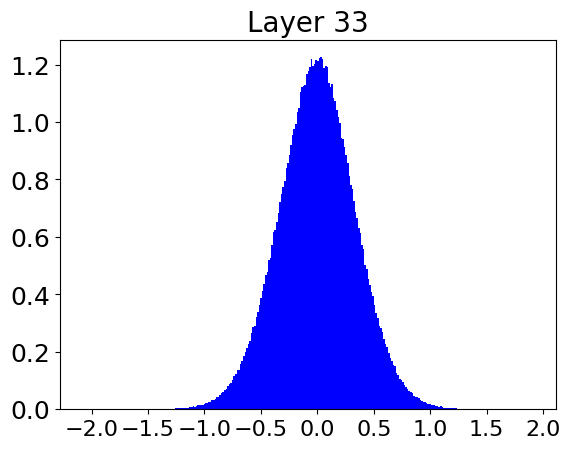

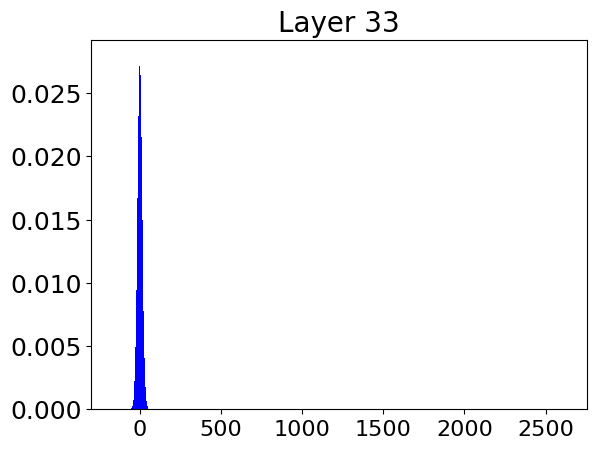

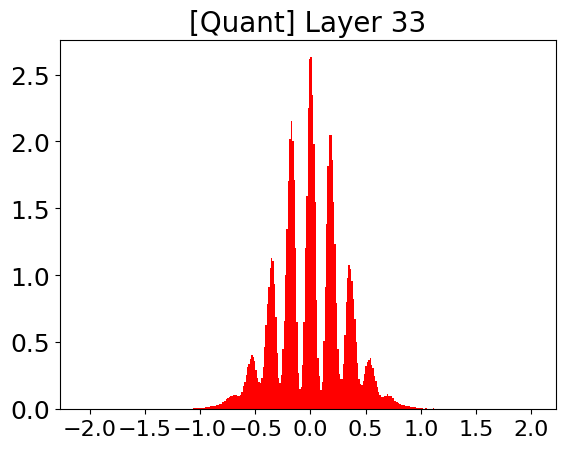

In [12]:
plt.hist(layerNorm_3_output, bins="scott", density=True, facecolor='b')
plt.title("Layer 33", fontdict={"size": 20})
plt.yticks(size = 18)
plt.xticks(size = 16)
plt.savefig("figs/layerNorm_33_output.pdf")
plt.show()

plt.hist(layerNorm_3_input, bins="scott", density=True, facecolor='b')
plt.title("Layer 33", fontdict={"size": 20})
plt.yticks(size = 18)
plt.xticks(size = 16)
plt.savefig("figs/layerNorm_33_input.pdf")
plt.show()

plt.hist(quant_layerNorm_3_output, bins="scott", density=True, facecolor='r')
plt.title("[Quant] Layer 33", fontdict={"size": 20})
plt.yticks(size = 18)
plt.xticks(size = 16)
plt.savefig("figs/quant_layerNorm_33_output.pdf")
plt.show()

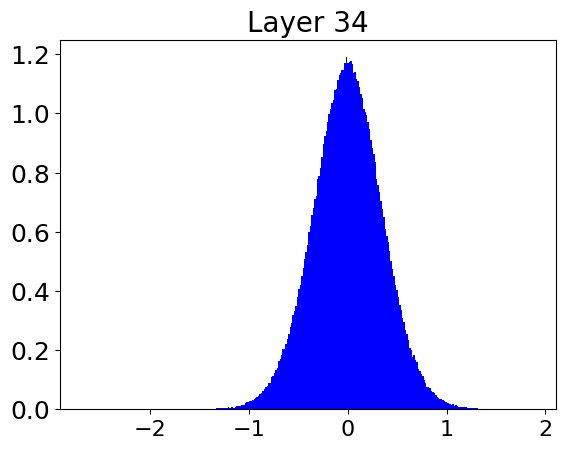

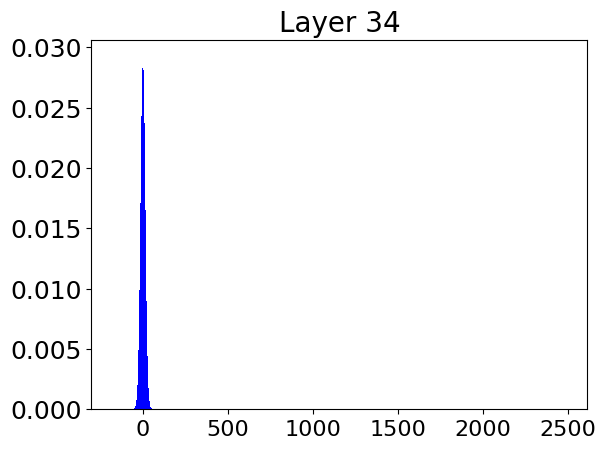

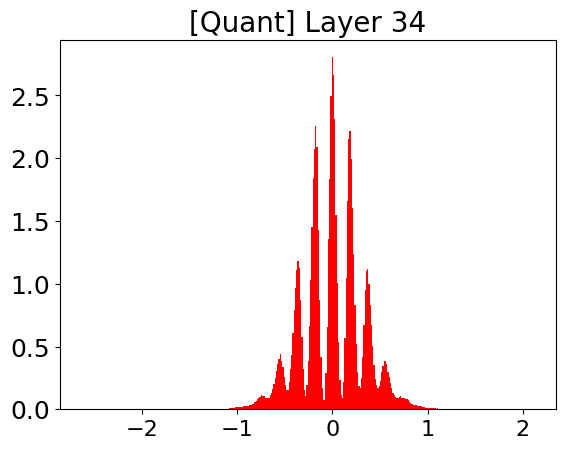

In [13]:
plt.hist(layerNorm_4_output, bins="scott", density=True, facecolor='b')
plt.title("Layer 34", fontdict={"size": 20})
plt.yticks(size = 18)
plt.xticks(size = 16)
plt.savefig("figs/layerNorm_34_output.pdf")
plt.show()

plt.hist(layerNorm_4_input, bins="scott", density=True, facecolor='b')
plt.title("Layer 34", fontdict={"size": 20})
plt.yticks(size = 18)
plt.xticks(size = 16)
plt.savefig("figs/layerNorm_34_input.pdf")
plt.show()

plt.hist(quant_layerNorm_4_output, bins="scott", density=True, facecolor='r')
plt.title("[Quant] Layer 34", fontdict={"size": 20})
plt.yticks(size = 18)
plt.xticks(size = 16)
plt.savefig("figs/quant_layerNorm_34_output.pdf")
plt.show()

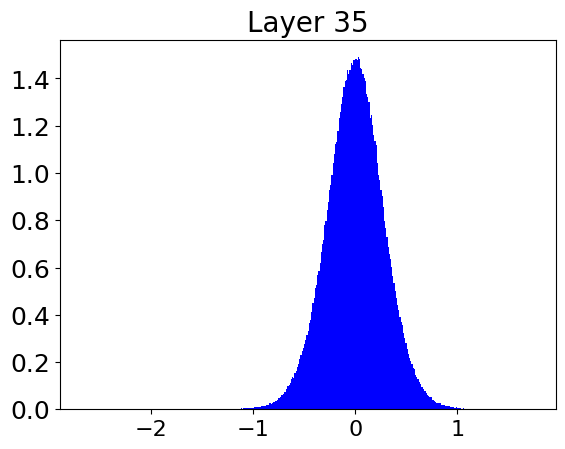

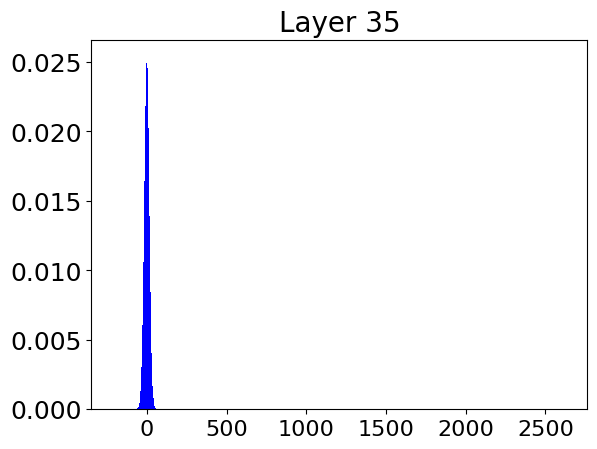

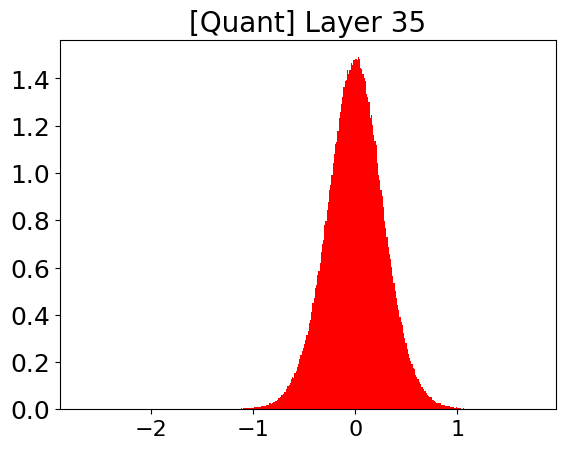

In [14]:
plt.hist(layerNorm_5_output, bins="scott", density=True, facecolor='b')
plt.title("Layer 35", fontdict={"size": 20})
plt.yticks(size = 18)
plt.xticks(size = 16)
plt.savefig("figs/layerNorm_35_output.pdf")
plt.show()

plt.hist(layerNorm_5_input, bins="scott", density=True, facecolor='b')
plt.title("Layer 35", fontdict={"size": 20})
plt.yticks(size = 18)
plt.xticks(size = 16)
plt.savefig("figs/layerNorm_35_input.pdf")
plt.show()

plt.hist(quant_layerNorm_5_output, bins="scott", density=True, facecolor='r')
plt.title("[Quant] Layer 35", fontdict={"size": 20})
plt.yticks(size = 18)
plt.xticks(size = 16)
plt.savefig("figs/quant_layerNorm_35_output.pdf")
plt.show()